# Merfish to visium registration

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
import os
import glob
import torch

from scipy.stats import rankdata
import nrrd
import time

<IPython.core.display.Javascript object>


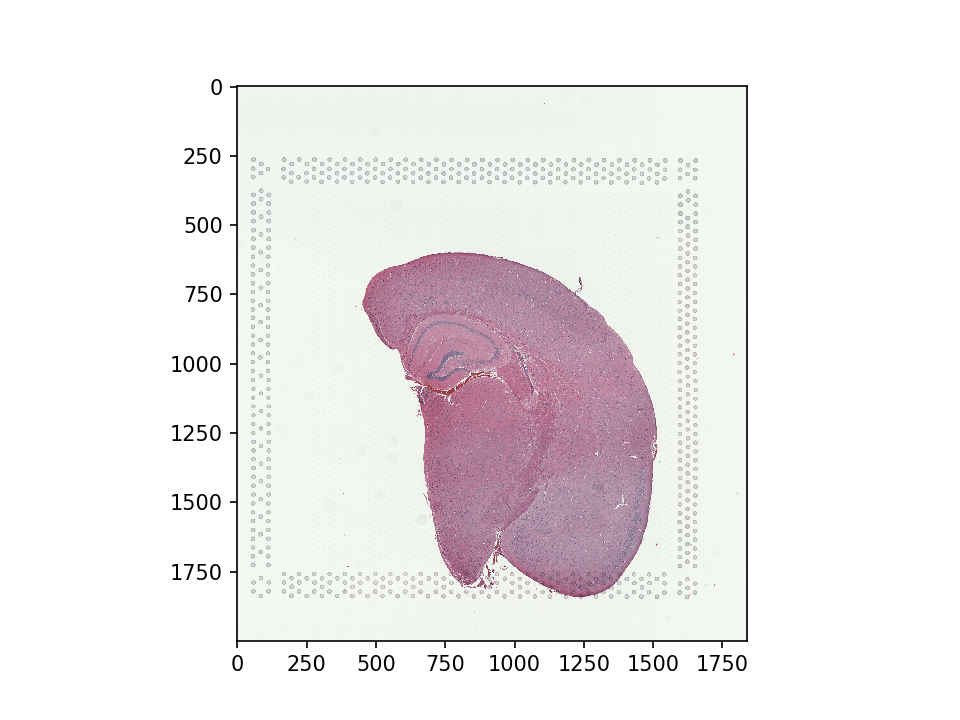

In [2]:
# visium
visium_file = '/mnt/data/merfish/Visium/spatial/tissue_hires_image.png'
visium_file = '/mnt/data/merfish/Visium/spatial/tissue_lowres_image.png'
visium_file = 'tissue_hires_image.png'
V = plt.imread(visium_file)
fig,ax = plt.subplots()
ax.imshow(V)

In [3]:
files = glob.glob('/mnt/data/merfish/OneDrive_1_8-5-2021/*metadata*.csv.gz')
files.sort()
files

['/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate1_cell_metadata_S1R1.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate2_cell_metadata_S1R2.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate3_cell_metadata_S1R3.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate1_cell_metadata_S2R1.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate2_cell_metadata_S2R2.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_metadata_S2R3.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice3_Replicate1_cell_metadata_S3R1.csv.gz',
 '/mnt/data/merfish/OneDrive_1_8-5-2021/datasets_mouse_brain_map_Brai

In [4]:
fname = files[-4]

<IPython.core.display.Javascript object>


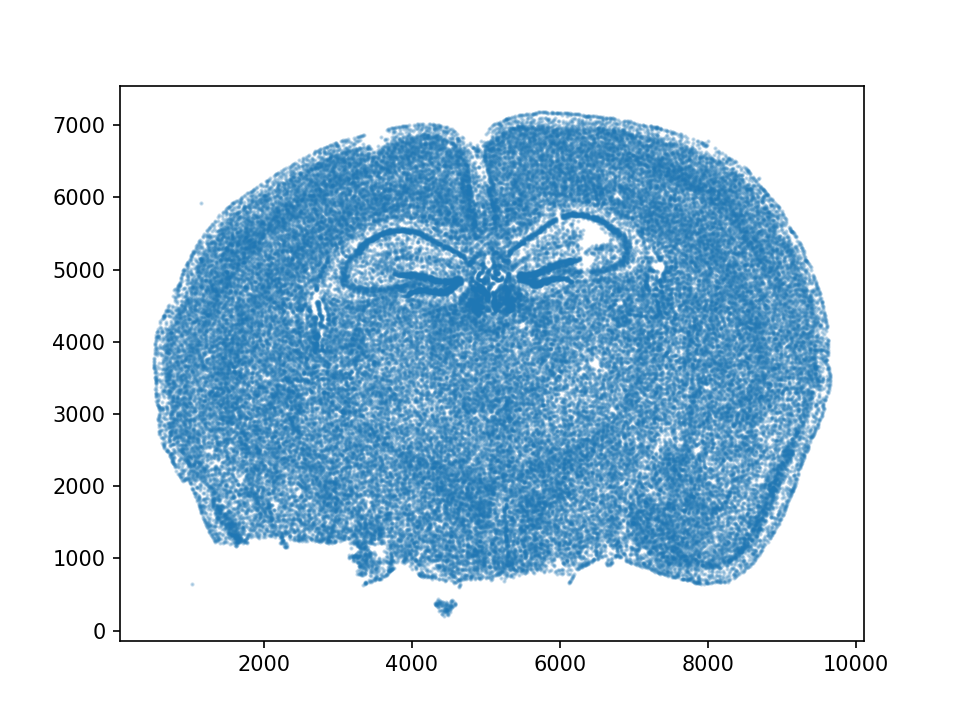

(256, 336)


<IPython.core.display.Javascript object>


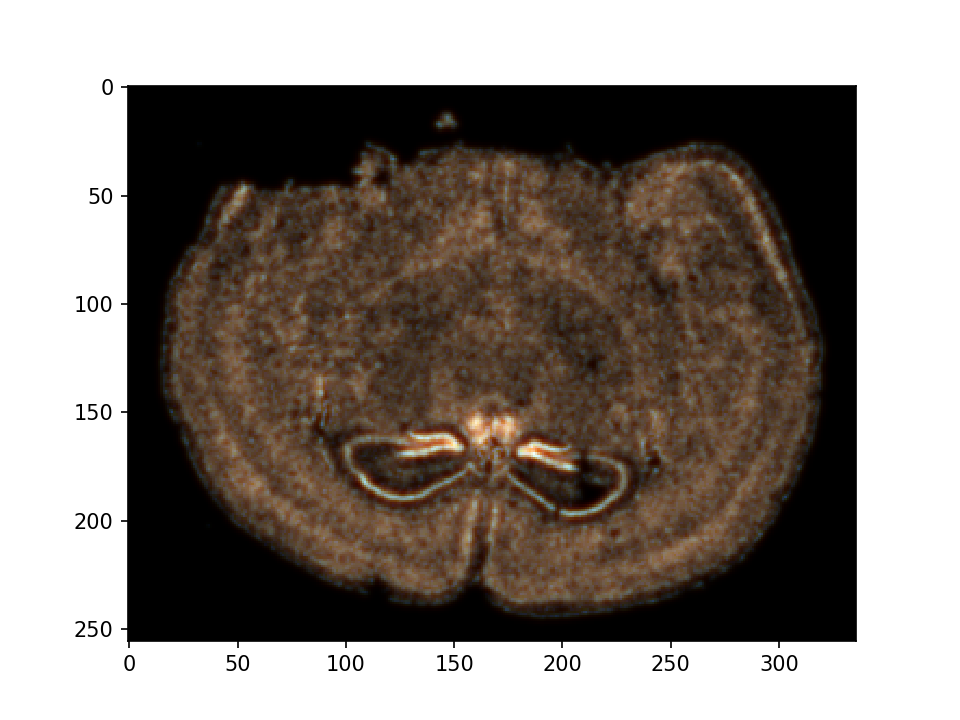

0 of 85958
10000 of 85958
20000 of 85958
30000 of 85958
40000 of 85958
50000 of 85958
60000 of 85958
70000 of 85958
80000 of 85958
85957 of 85958


In [5]:
names = os.path.splitext(fname)
if names[1] == '.gz':
    names = os.path.splitext(names[0])
outname = names[0] + '_with_structure_id_v02.csv'


df = pd.read_csv(fname.replace('by_gene','metadata'))
x = np.array(df['center_x'])
y = np.array(df['center_y'])
v = np.array(df['volume'])
N = x.shape[0]
mat = np.array([[9.20788192749023E+00, 0E+00, -3.77225189208984E+02],
            [0E+00, 9.20783615112305E+00, 9.39383850097656E+02],
            [0E+00, 0E+00, 1E+00 ]])
mat = np.eye(3)
xy = np.stack((x,y),0)
xy = mat[:2,:2]@xy + mat[:2,-1][:,None]
x,y = xy
f,ax = plt.subplots()
ax.scatter(x,y,s=1,alpha=0.25)
#ax.invert_yaxis()
# what are the units in xy
# they should be microns
# they're probably pixel, the conversion factor is
f.canvas.draw()


# now we want to rasterize
minx = np.min(x)
maxx = np.max(x)
miny = np.min(y)
maxy = np.max(y)
expand = 1.1
minx,maxx = (minx+maxx)/2.0 - (maxx-minx)/2.0*expand, (minx+maxx)/2.0 + (maxx-minx)/2.0*expand
miny,maxy = (miny+maxy)/2.0 - (maxy-miny)/2.0*expand, (miny+maxy)/2.0 + (maxy-miny)/2.0*expand

dx = 50 # I will register to 50 micron atlas
dx = 30
X_ = np.arange(minx,maxx,dx)
Y_ = np.arange(miny,maxy,dx)
X = np.stack(np.meshgrid(X_,Y_))
blur = 0.75 # gaussian std in voxels
blur = 1.0
blur = 2.0
blur = 1.0
blur = 1.5
blur = 1.0
W = np.zeros((len(Y_),len(X_)))
W1 = np.zeros((len(Y_),len(X_)))
W2 = np.zeros((len(Y_),len(X_)))
print(W.shape)


f,ax = plt.subplots()
count = 0
for x_,y_ in zip(x,y):
    # to speed things up I shoul index
    # to do this I'd have to find row and column indices
    col = np.round((x_ - X_[0])/dx).astype(int)
    row = np.round((y_ - X_[1])/dx).astype(int)
    row0 = np.floor(row-blur*3).astype(int)
    row1 = np.ceil(row+blur*3).astype(int)
    rows = np.arange(row0,row1+1)
    #rows = np.arange(row,row+blur*3+1)
    #rows_ = np.arange(row,row-blur*3-1,-1)
    #rows__ = np.concatenate((rows_[::-1],rows[1:])).astype(int)
    #cols = np.arange(col,col+blur*3+1)
    #cols_ = np.arange(col,col-blur*3-1,-1)
    #cols__ = np.concatenate((cols_[::-1],cols[1:])).astype(int)

    ## this step is incrementing one pixel at a time, it is way way faster
    #I[c_,row,col] += 1.0
    #W[row,col] += 1.0

    k = np.exp( - ( (X[0] - x_)**2 + (X[1] - y_)**2 )/(2.0*(dx*blur*2)**2)  )
    k /= np.sum(k)
    #I[c_] += k 
    W += k
    wavelet = False
    #wavelet = True
    
    k1 = np.exp( - ( (X[0] - x_)**2 + (X[1] - y_)**2 )/(2.0*(dx*blur)**2)  )
    k1 /= np.sum(k1)
    W1 += (k1-k*wavelet)
    
    k2 = np.exp( - ( (X[0] - x_)**2 + (X[1] - y_)**2 )/(2.0*(dx*blur*0.5)**2)  )
    k2 /= np.sum(k2)
    W2 += (k2-k1*wavelet)

    if not count%10000 or count==(x.shape[0]-1):
        print(f'{count} of {x.shape[0]}')

        ax.cla()
        ax.imshow(np.stack((W/np.max(W),
                            (W1-np.min(W1))/(np.max(W1)-np.min(W1)),
                             (W2-np.min(W2))/(np.max(W2)-np.min(W2))),-1))
        f.canvas.draw()

    count += 1
W1 = np.abs(W1)
W2 = np.abs(W2)
extent = (X_[0],X_[-1],Y_[0],Y_[-1])
ax.cla()
ax.imshow(np.stack((W/np.max(W),W1/np.max(W1),W2/np.max(W2)),-1))
f.canvas.draw()
f.savefig(outname[:-4]+'_image.png')
    

In [6]:
# Now I need to align W and J
M = np.stack((W,W1,W2),0)

In [7]:
# now we will use torch
import torch
from torch.nn.functional import grid_sample
# build an interp function from grid sample
def interp(x,I,phii,**kwargs):
    '''
    Interpolate the image I, with regular grid positions stored in x (1d arrays),
    at the positions stored in phii (2D arrays with first channel storing component)
    '''
    # first we have to normalize phii to the range -1,1    
    I = torch.as_tensor(I)
    phii = torch.as_tensor(phii)
    phii = torch.clone(phii)
    for i in range(2):
        phii[i] -= x[i][0]
        phii[i] /= x[i][-1] - x[i][0]
    # note the above maps to 0,1
    phii *= 2.0
    # to 0 2
    phii -= 1.0
    # done

    # NOTE I should check that I can reproduce identity
    # note that phii must now store x,y,z along last axis
    # is this the right order?
    # I need to put batch (none) along first axis
    # what order do the other 3 need to be in?    
    out = grid_sample(I[None],phii.flip(0).permute((1,2,0))[None],align_corners=True,**kwargs)
    # note align corners true means square voxels with points at their centers
    # post processing, get rid of batch dimension

    return out[0]


def interp(x,I,phii,**kwargs):
    '''
    Interpolate the image I, with regular grid positions stored in x (1d arrays),
    at the positions stored in phii (3D arrays with first channel storing component)
    
    Make it for 2d
    '''
    # first we have to normalize phii to the range -1,1    
    I = torch.as_tensor(I)
    phii = torch.as_tensor(phii)
    phii = torch.clone(phii)
    for i in range(2):
        phii[i] -= x[i][0]
        phii[i] /= x[i][-1] - x[i][0]
    # note the above maps to 0,1
    phii *= 2.0
    # to 0 2
    phii -= 1.0
    # done

    # NOTE I should check that I can reproduce identity
    # note that phii must now store x,y,z along last axis
    # is this the right order?
    # I need to put batch (none) along first axis
    # what order do the other 3 need to be in?    
    out = grid_sample(I[None],phii.flip(0).permute((1,2,0))[None],align_corners=True,**kwargs)
    # note align corners true means square voxels with points at their centers
    # post processing, get rid of batch dimension

    return out[0]

In [8]:
# timesteps will be along the first axis
def v_to_phii(xv,v):
    '''
    Inputs: 
        xv -> list of 1D tensors describing locations of sample points
        v -> 5D (nt,3,v0,v1,v2) velocity field
    Output:
        phii (inverse map) computed by method of characteristics

    '''
    XV = torch.stack(torch.meshgrid(xv))
    phii = torch.clone(XV)
    dt = 1.0/v.shape[0]
    for t in range(v.shape[0]):
        Xs = XV - v[t]*dt
        phii = interp(xv,phii-XV,Xs)+Xs
    return phii

In [9]:
def to_A(L,T):
    O = torch.tensor([0.,0.,1.],device=L.device,dtype=L.dtype)
    return torch.cat((torch.cat((L,T[:,None]),1),O[None]))

In [10]:
M.shape,V.shape

((3, 256, 336), (2000, 1838, 3))

In [11]:
dtype = torch.float64
device = 'cpu'
I = torch.as_tensor(M/np.mean(np.abs(M)),dtype=dtype,device=device) # for label
J = torch.as_tensor(V.transpose(2,0,1),dtype=dtype,device=device)[:3]

xI = [torch.as_tensor(Y_,device=device,dtype=dtype),
      torch.as_tensor(X_,device=device,dtype=dtype)]
XI = torch.stack(torch.meshgrid(xI),-1)

dJ = 15.0
dJ = 1.0 # just pixels, no origin
xJ = [torch.arange(J.shape[1],device=device,dtype=dtype)*dJ - (J.shape[1]-1)*dJ/2.0*0,
      torch.arange(J.shape[2],device=device,dtype=dtype)*dJ - (J.shape[2]-1)*dJ/2.0*0]
XJ = torch.stack(torch.meshgrid(xJ),-1)

extentJ = (xJ[1][0].item()-dJ/2.0,
          xJ[1][-1].item()+dJ/2.0,
          xJ[0][-1].item()+dJ/2.0,
          xJ[0][0].item()-dJ/2.0)


/home/dtward/.local/intelpython3/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:
# we will need to downsample J
Jd = torch.clone(J)
xJd = [torch.clone(x) for x in xJ]
ndown = 2
for i in range(ndown):
    nd = np.array(Jd.shape)//2
    Jd = Jd[:,0:nd[1]*2:2]*0.5 + Jd[:,1:nd[1]*2:2]*0.5
    Jd = Jd[:,:,0:nd[2]*2:2]*0.5 + Jd[:,:,1:nd[2]*2:2]*0.5
    xJd = [ (xJd[i][0:nd[i+1]*2:2] + xJd[i][1:nd[i+1]*2:2])*0.5 for i in range(2)]
    
XJd = torch.stack(torch.meshgrid(xJd),-1)    
dJd = [d*2.0**ndown for d in [dJ,dJ]]

In [13]:
def extent_from_x(xJ):
    dJ = [x[1]-x[0] for x in xJ]
    extentJ = ( (xJ[1][0] - dJ[1]/2.0).item(),
               (xJ[1][-1] + dJ[1]/2.0).item(),
               (xJ[0][-1] + dJ[0]/2.0).item(),
               (xJ[0][0] - dJ[0]/2.0).item())
    return extentJ

<IPython.core.display.Javascript object>


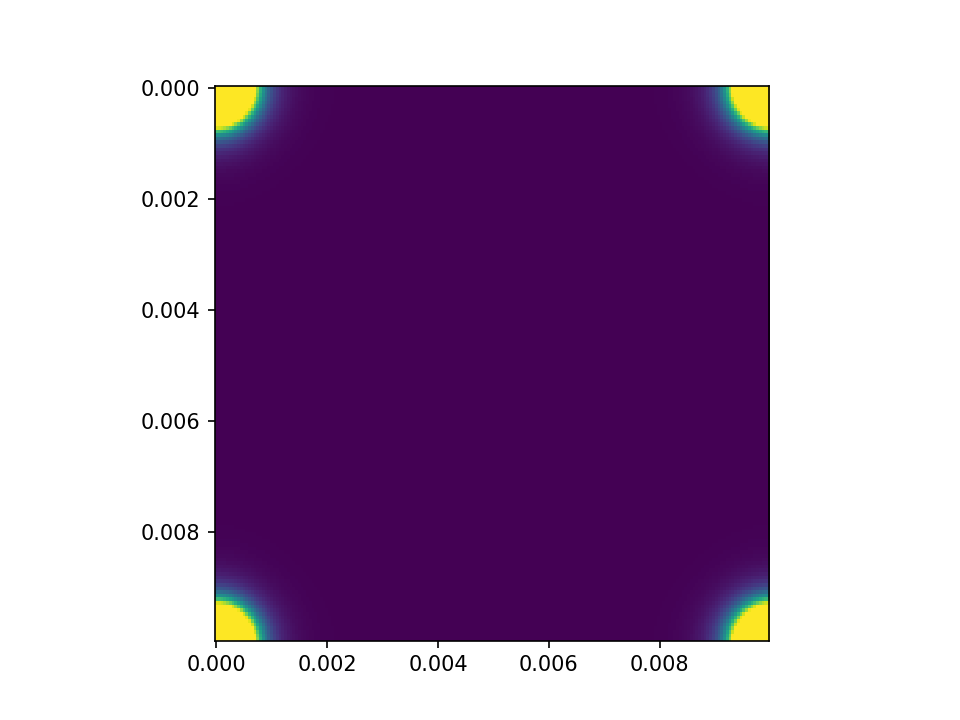

<IPython.core.display.Javascript object>


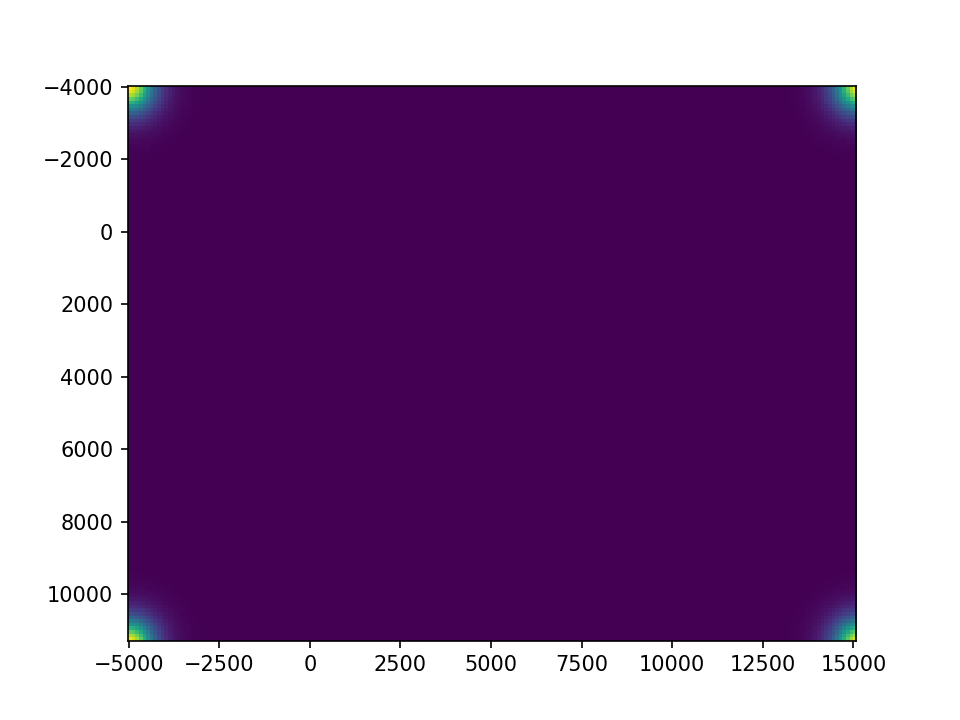

In [14]:
a = 200.0
p = 2.0
expand = 2.0
minv = torch.as_tensor([x[0] for x in xI],device=device,dtype=dtype)
maxv = torch.as_tensor([x[-1] for x in xI],device=device,dtype=dtype)
minv,maxv = (minv+maxv)*0.5 + 0.5*torch.tensor([-1.0,1.0],device=device,dtype=dtype)[...,None]*(maxv-minv)*expand
xv = [torch.arange(m,M,a*0.5,device=device,dtype=dtype) for m,M in zip(minv,maxv)]
extentV = extent_from_x(xv)
dv = torch.as_tensor([x[1]-x[0] for x in xv],device=device,dtype=dtype)
XV = torch.stack(torch.meshgrid(xv),-1)
fv = [torch.arange(n,device=device,dtype=dtype)/n/d for n,d in zip(XV.shape,dv)]
extentF = extent_from_x(fv)
FV = torch.stack(torch.meshgrid(fv),-1)
LL = (1.0 + 2.0*a**2* torch.sum( (1.0 - torch.cos(2.0*np.pi*FV*dv))/dv**2 ,-1))**(p*2.0)

K = 1.0/LL
fig,ax = plt.subplots()
ax.imshow(K,vmin=0.0,vmax=0.1,extent=extentF)
#fig,ax = plt.subplots()
#ax.imshow(K[0].cpu())
DV = torch.prod(dv)
Ki = torch.fft.ifftn(K).real
fig,ax = plt.subplots()
ax.imshow(Ki,vmin=0.0,extent=extentV)

In [15]:
L = torch.eye(2,device=device,dtype=dtype,requires_grad=True)
L.data[0,0] = -1.0
L.data *= 0.25
T = torch.zeros(2,device=device,dtype=dtype,requires_grad=True)
T.data[0] = xI[0][-1]/2.0
T.data[1] = -xI[1][-1]/2.0*1.1

# velocity

nt = 3
v = torch.zeros((nt,XV.shape[0],XV.shape[1],XV.shape[2]),device=device,dtype=dtype,requires_grad=True)




In [16]:
niter = 1
diffeo_start = 10
epL = 1e-8
epT = 2e0
epV = 1e3

<IPython.core.display.Javascript object>


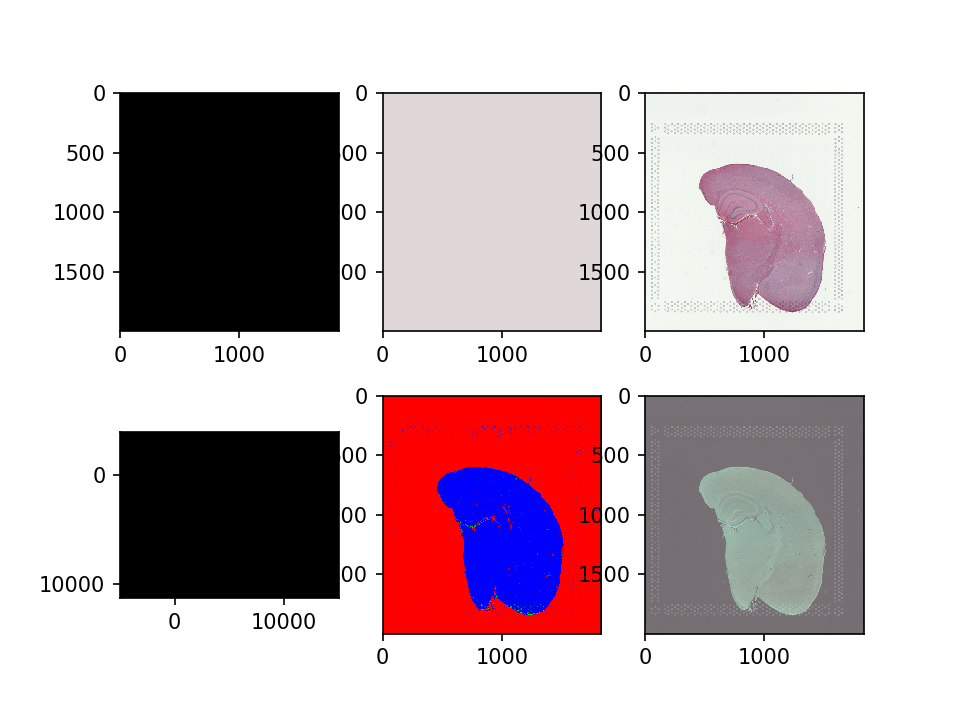

<IPython.core.display.Javascript object>


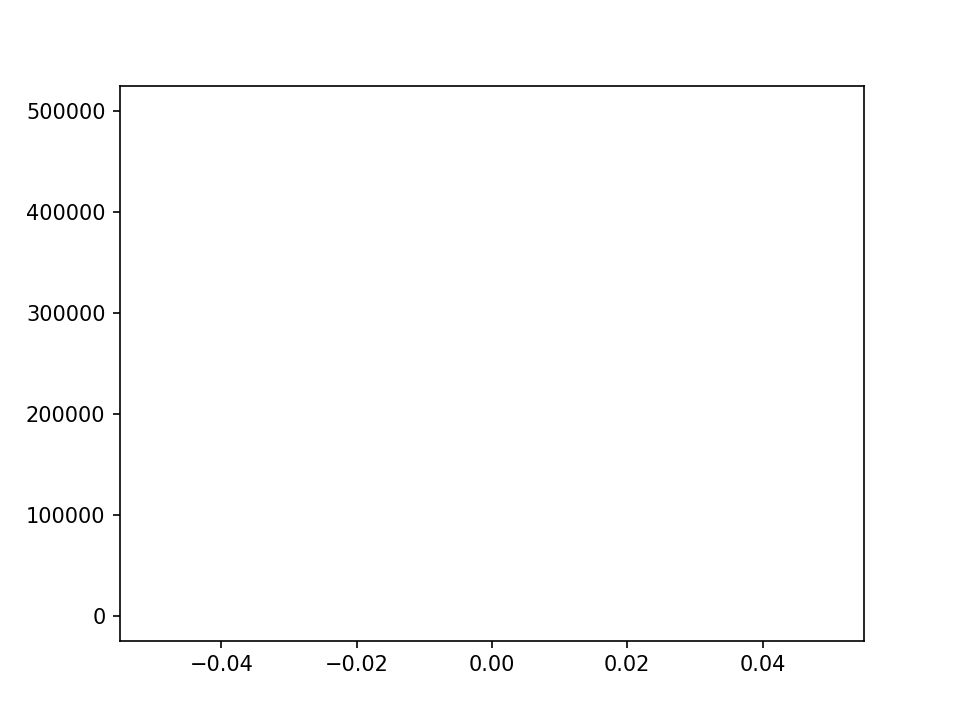

/home/dtward/.local/intelpython3/lib/python3.7/site-packages/torch/autograd/__init__.py:156: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:244.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


In [17]:
WM = torch.ones(Jd[0].shape,dtype=J.dtype,device=J.device)*0.6
WB = torch.ones(Jd[0].shape,dtype=J.dtype,device=J.device)*0.2
WA = torch.ones(Jd[0].shape,dtype=J.dtype,device=J.device)*0.2
sigmaM = 0.1
sigmaB = 0.1
sigmaA = 0.1
sigmaR = 1e4
fig,ax = plt.subplots(2,3)
ax = ax.ravel()
figE,axE = plt.subplots()
Esave = []

try:
    L.grad.zero_()
except:
    pass
try:
    T.grad.zero_()
except:
    pass
for it in range(niter):
    # make A
    A = to_A(L,T)
    # Ai
    Ai = torch.linalg.inv(A)
    # transform sample points
    Xs = (Ai[:2,:2]@XJd[...,None])[...,0] + Ai[:2,-1]    
    # now diffeo, not semilagrange here
    for t in range(nt-1,-1,-1):
        Xs = Xs + interp(xv,-v[t].permute(2,0,1),Xs.permute(2,0,1)).permute(1,2,0)/nt       
    
    # transform image
    AI = interp(xI,I,Xs.permute(2,0,1))
    
    # transform the contrast
    B = torch.ones(1+AI.shape[0],AI.shape[1]*AI.shape[2],device=AI.device,dtype=AI.dtype)
    B[1:] = AI.reshape(AI.shape[0],-1)
    with torch.no_grad():    
        BB = B@(B*WM.ravel()).T
        BJ = B@((Jd*WM).reshape(Jd.shape[0],Jd.shape[1]*Jd.shape[2])).T
        small = 0.1
        coeffs = torch.linalg.solve(BB + small*torch.eye(BB.shape[0],device=BB.device,dtype=BB.dtype),BJ)
    fAI = ((B.T@coeffs).T).reshape(Jd.shape)
    
    # objective function
    EM = torch.sum((fAI - Jd)**2*WM)/2.0/sigmaM**2
    ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(1,2)))**2,dim=(0,-1))*LL)*DV/2.0/v.shape[1]/v.shape[2]/sigmaR**2
    E = EM + ER
    Esave.append( (E.item(), EM.item(), ER.item()) )
    # gradient update
    E.backward()
    with torch.no_grad():
        L -= (epL/(1.0 + (it>=diffeo_start)*9))*L.grad
        T -= (epT/(1.0 + (it>=diffeo_start)*9))*T.grad
        
        L.grad.zero_()
        T.grad.zero_()
        
        # v grad
        vgrad = v.grad
        # smooth it
        vgrad = torch.fft.ifftn(torch.fft.fftn(vgrad,dim=(1,2))*K[...,None],dim=(1,2)).real
        if it >= diffeo_start:
            v -= vgrad*epV
        v.grad.zero_()
        
    
    # update weights
    if not it%5:
        with torch.no_grad():
            # M step for these params
            muA = torch.sum(WA*Jd,dim=(-1,-2))/torch.sum(WA)
            muB = torch.sum(WB*Jd,dim=(-1,-2))/torch.sum(WB)
            if it == 0:
                muA = torch.ones(Jd.shape[0],device=J.device,dtype=J.dtype)*0.3
                muB = torch.ones(Jd.shape[0],device=J.device,dtype=J.dtype)*0.6
            W = torch.stack((WM,WA,WB))
            pi = torch.sum(W,dim=(1,2))
            pi += torch.max(pi)*1e-3
            pi /= torch.sum(pi)
            
            # now the E step, update the weights
            WM = pi[0]* torch.exp( -torch.sum((fAI - Jd)**2,0)/2.0/sigmaM**2 )/np.sqrt(2.0*np.pi*sigmaM**2)**J.shape[0]
            WA = pi[1]* torch.exp( -torch.sum((muA[...,None,None] - Jd)**2,0)/2.0/sigmaA**2 )/np.sqrt(2.0*np.pi*sigmaA**2)**J.shape[0]
            WB = pi[2]* torch.exp( -torch.sum((muB[...,None,None] - Jd)**2,0)/2.0/sigmaB**2 )/np.sqrt(2.0*np.pi*sigmaB**2)**J.shape[0]
            WS = WM+WB+WA
            WS += torch.max(WS)*1e-3
            WM /= WS
            WB /= WS
            WA /= WS
            
        

    
    # draw
    if not it%10:
        ax[0].cla()
        ax[0].imshow(((AI-torch.amin(AI,(1,2))[...,None,None])/(torch.amax(AI,(1,2))-torch.amin(AI,(1,2)))[...,None,None]).permute(1,2,0).clone().detach().cpu(),extent=extentJ)
        ax[1].cla()    
        ax[1].imshow(fAI.permute(1,2,0).clone().detach().cpu(),extent=extentJ)

        ax[5].cla()
        ax[5].imshow((fAI - Jd).permute(1,2,0).clone().detach().cpu()*0.5+0.5,extent=extentJ)

        ax[2].cla()
        ax[2].imshow(Jd.permute(1,2,0).cpu(),extent=extentJ)

        ax[4].cla()
        ax[4].imshow(torch.stack((WM,WA,WB),-1).clone().detach().cpu(),extent=extentJ)



        toshow = v[0].clone().detach().cpu()
        toshow /= torch.max(torch.abs(toshow))
        toshow = toshow*0.5+0.5
        toshow = torch.cat((toshow,torch.zeros_like(toshow[...,0][...,None])),-1)   
        ax[3].cla()
        ax[3].imshow(toshow,extent=extentV)

        axE.cla()
        axE.plot(Esave)


        fig.canvas.draw()
        figE.canvas.draw()
    

In [18]:
# we want allen, merfish, and visium
# we could use one as an intermediary, rather than all pairs.
# jean has olfactoroy bulb datasets.
# daniel add landmarks to update this

In [19]:
torch.amax(AI,dim=(1,2))

tensor([0., 0., 0.], dtype=torch.float64, grad_fn=<AmaxBackward0>)

In [20]:
torch.max(v)

tensor(0., dtype=torch.float64, grad_fn=<MaxBackward1>)

In [21]:
dI = [x[1]-x[0] for x in xI]
extentI = [xI[1][0]-dI[1]/2.0, xI[1][-1]+dI[1]/2.0, xI[0][-1]+dI[0]/2.0, xI[0][0]-dI[0]/2.0]
dJ = [x[1]-x[0] for x in xJ]
extentJ = [xJ[1][0]-dJ[1]/2.0, xJ[1][-1]+dJ[1]/2.0, xJ[0][-1]+dJ[0]/2.0, xJ[0][0]-dJ[0]/2.0]

In [22]:
I.shape,[len(x) for x in xI]

(torch.Size([3, 256, 336]), [256, 336])

In [23]:
# save the images as an NPZ and do landmarking
np.savez('images_to_landmark_visium2.npz',I=I.permute(1,2,0).cpu().numpy(),J=J.permute(1,2,0).cpu().numpy(),xI=np.array([x.cpu().numpy() for x in xI],dtype=object),
         xJ=np.array([x.cpu().numpy() for x in xJ],dtype=object))

In [24]:
data = np.load('visium2_points.npz')
pointsI = np.array(data['pointsI'][...,::-1])
pointsJ = np.array(data['pointsJ'][...,::-1])

<IPython.core.display.Javascript object>


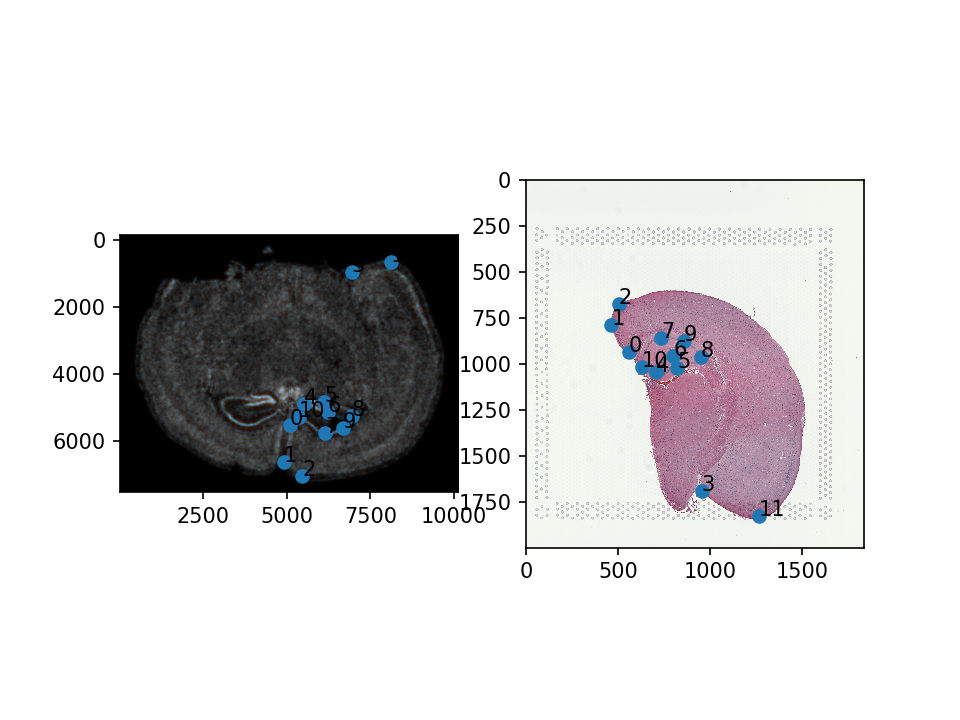

In [25]:
# let's place some landmarks and continue
fig,ax = plt.subplots(1,2)
ax[0].imshow((I/I.max()).permute(1,2,0).cpu(), extent=extentI)
ax[1].imshow((J).permute(1,2,0).cpu(), extent=extentJ)

ax[0].scatter(pointsI[:,1],pointsI[:,0])
ax[1].scatter(pointsJ[:,1],pointsJ[:,0])
for i in range(pointsI.shape[0]):
    ax[0].text(pointsI[i,1],pointsI[i,0],f'{i}')
    ax[1].text(pointsJ[i,1],pointsJ[i,0],f'{i}')

In [26]:
def clip(I):
    I = torch.clone(I)
    I[I<0]=0
    I[I>1]=1
    return I

<IPython.core.display.Javascript object>


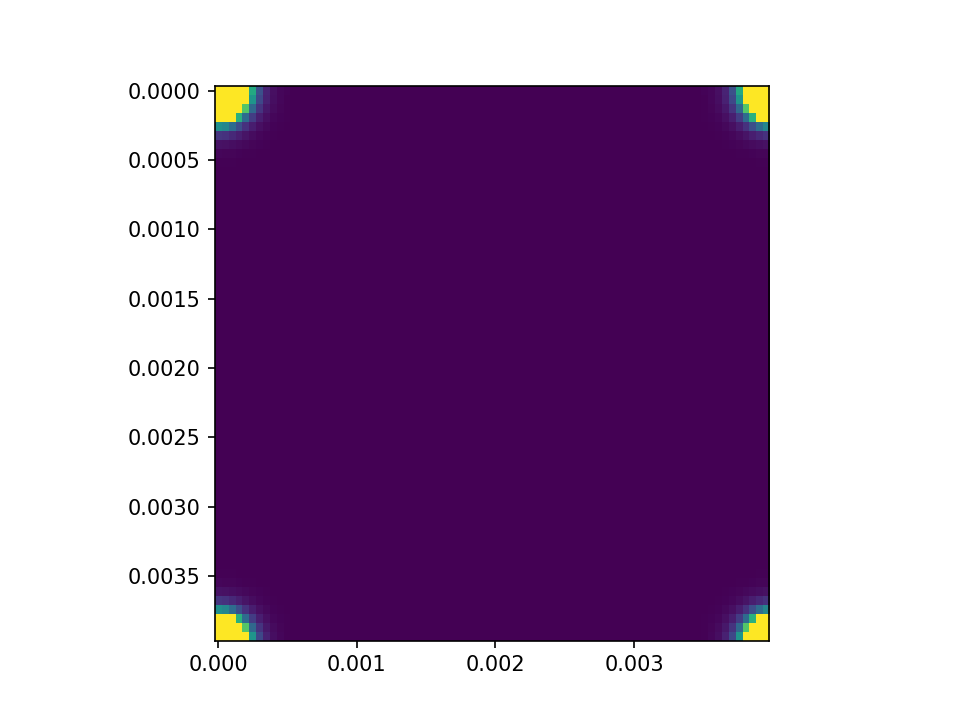

<IPython.core.display.Javascript object>


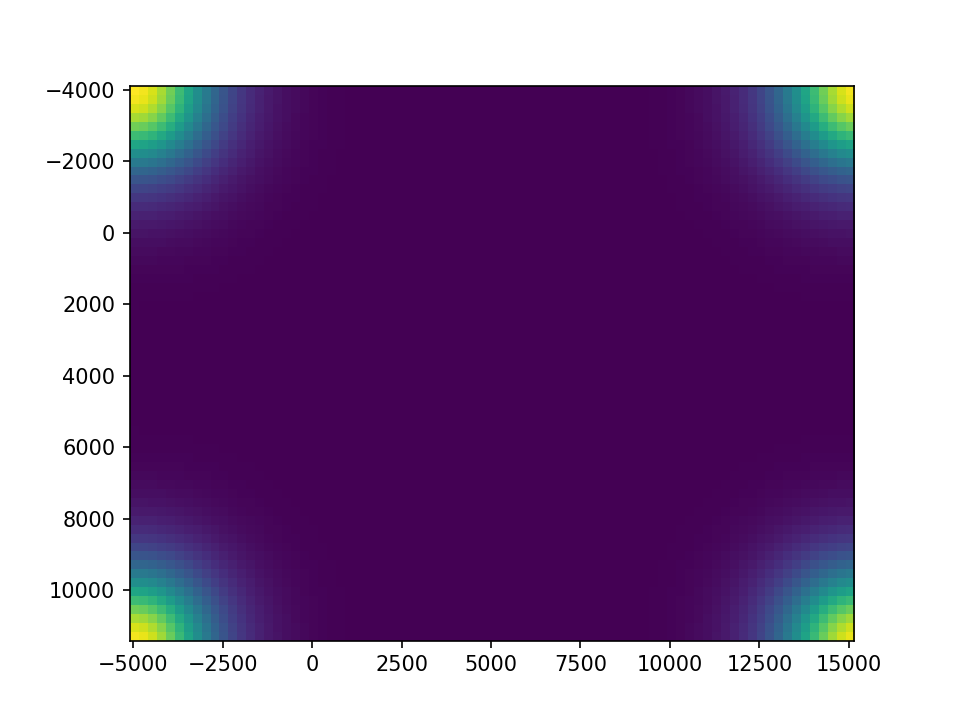

<IPython.core.display.Javascript object>


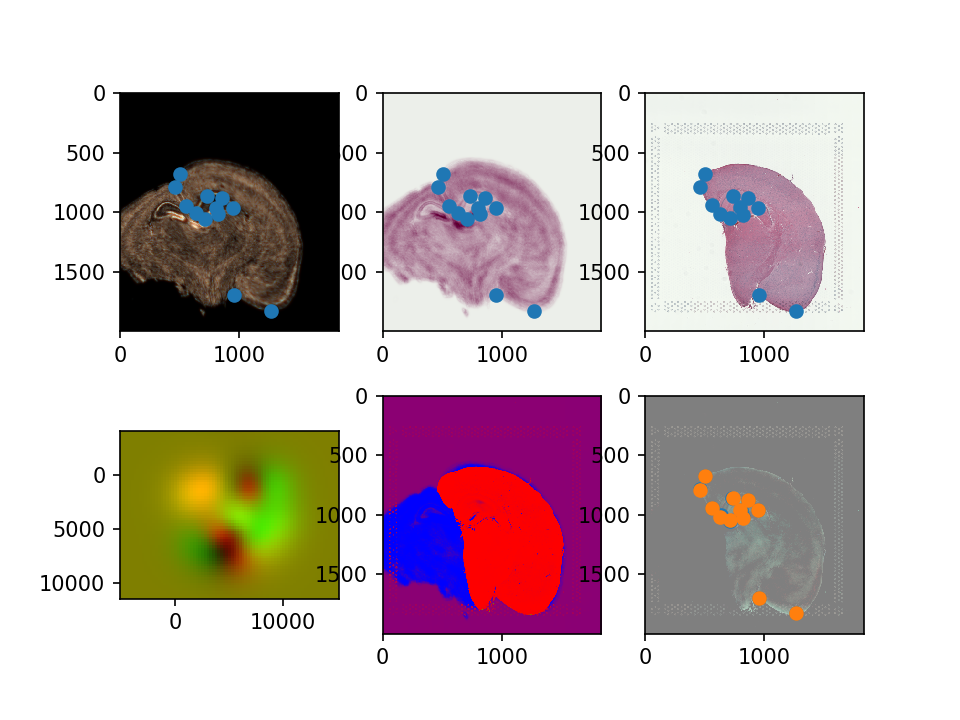

<IPython.core.display.Javascript object>


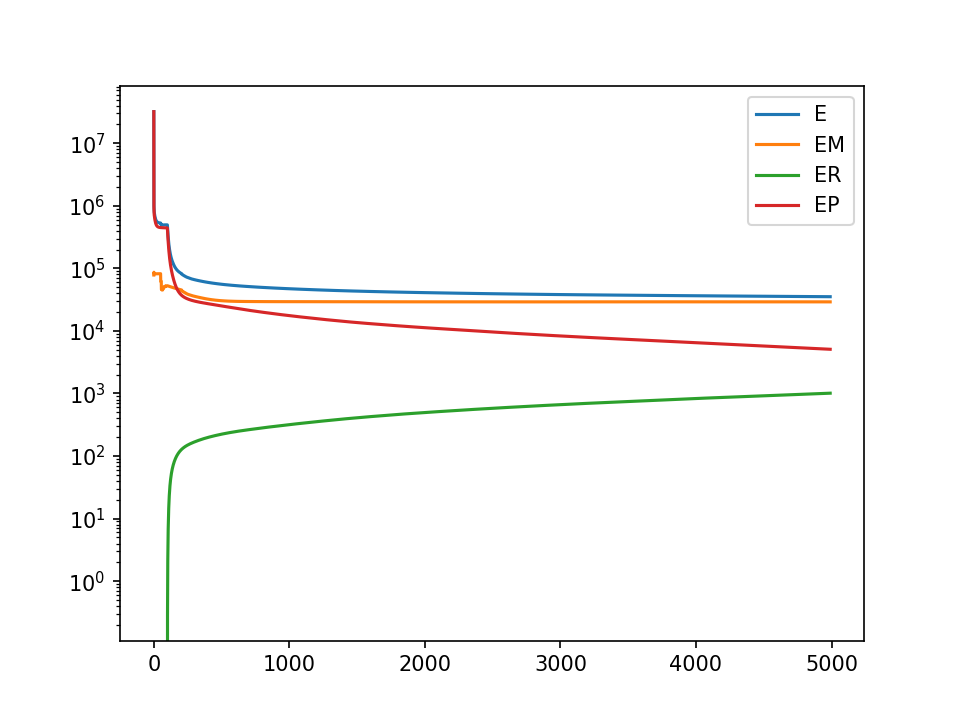

In [27]:
# todo
# implement local?
# more iters

niter = 2000
diffeo_start = 100
epL = 5e-11
epT = 5e-4
epV = 5e1
niter = 5000

L = torch.eye(2,device=device,dtype=dtype,requires_grad=True)
L.data[0,0] = -1.0
L.data[:2,:2] *= 0.2
T = torch.zeros(2,device=device,dtype=dtype,requires_grad=True)
T.data[0] = +2000.0
#T.data[1] = -xI[1][-1]/2.0*1.1

# velocity
a = 500.0
p = 3.0
expand = 2.0
minv = torch.as_tensor([x[0] for x in xI],device=device,dtype=dtype)
maxv = torch.as_tensor([x[-1] for x in xI],device=device,dtype=dtype)
minv,maxv = (minv+maxv)*0.5 + 0.5*torch.tensor([-1.0,1.0],device=device,dtype=dtype)[...,None]*(maxv-minv)*expand
xv = [torch.arange(m,M,a*0.5,device=device,dtype=dtype) for m,M in zip(minv,maxv)]
extentV = extent_from_x(xv)
dv = torch.as_tensor([x[1]-x[0] for x in xv],device=device,dtype=dtype)
XV = torch.stack(torch.meshgrid(xv),-1)
fv = [torch.arange(n,device=device,dtype=dtype)/n/d for n,d in zip(XV.shape,dv)]
extentF = extent_from_x(fv)
FV = torch.stack(torch.meshgrid(fv),-1)
LL = (1.0 + 2.0*a**2* torch.sum( (1.0 - torch.cos(2.0*np.pi*FV*dv))/dv**2 ,-1))**(p*2.0)

K = 1.0/LL
fig,ax = plt.subplots()
ax.imshow(K,vmin=0.0,vmax=0.1,extent=extentF)
#fig,ax = plt.subplots()
#ax.imshow(K[0].cpu())
DV = torch.prod(dv)
Ki = torch.fft.ifftn(K).real
fig,ax = plt.subplots()
ax.imshow(Ki,vmin=0.0,extent=extentV)


nt = 3
v = torch.zeros((nt,XV.shape[0],XV.shape[1],XV.shape[2]),device=device,dtype=dtype,requires_grad=True)





WM = torch.ones(Jd[0].shape,dtype=J.dtype,device=J.device)*0.5
WB = torch.ones(Jd[0].shape,dtype=J.dtype,device=J.device)*0.4
WA = torch.ones(Jd[0].shape,dtype=J.dtype,device=J.device)*0.1
pointsI = torch.tensor(pointsI,device=J.device,dtype=J.dtype)
pointsJ = torch.tensor(pointsJ,device=J.device,dtype=J.dtype)
sigmaM = 0.2
sigmaB = 0.19
sigmaA = 0.3
sigmaR = 5e5
sigmaP = 2e-1
fig,ax = plt.subplots(2,3)
ax = ax.ravel()
figE,axE = plt.subplots()
Esave = []

try:
    L.grad.zero_()
except:
    pass
try:
    T.grad.zero_()
except:
    pass
for it in range(niter):
    # make A
    A = to_A(L,T)
    # Ai
    Ai = torch.linalg.inv(A)
    # transform sample points
    Xs = (Ai[:2,:2]@XJd[...,None])[...,0] + Ai[:2,-1]    
    # now diffeo, not semilagrange here
    for t in range(nt-1,-1,-1):
        Xs = Xs + interp(xv,-v[t].permute(2,0,1),Xs.permute(2,0,1)).permute(1,2,0)/nt
    # and points
    pointsIt = torch.clone(pointsI)
    for t in range(nt):
        pointsIt += interp(xv,v[t].permute(2,0,1),pointsIt.T[...,None])[...,0].T/nt
    pointsIt = (A[:2,:2]@pointsIt.T + A[:2,-1][...,None]).T
    
    # transform image
    AI = interp(xI,I,Xs.permute(2,0,1))
    
    # transform the contrast
    B = torch.ones(1+AI.shape[0],AI.shape[1]*AI.shape[2],device=AI.device,dtype=AI.dtype)
    B[1:4] = AI.reshape(AI.shape[0],-1)
    #B = torch.ones(10,AI.shape[1]*AI.shape[2],device=AI.device,dtype=AI.dtype)
    #B[1:4] = AI.reshape(AI.shape[0],-1)
    #B[4] = (AI[0][None]**2).reshape(1,-1)
    #B[5] = (AI[1][None]**2).reshape(1,-1)
    #B[6] = (AI[2][None]**2).reshape(1,-1)
    #B[7] = (AI[0][None]*AI[1][None]).reshape(1,-1)
    #B[8] = (AI[0][None]*AI[2][None]).reshape(1,-1)
    #B[9] = (AI[1][None]*AI[2][None]).reshape(1,-1)
    with torch.no_grad():    
        BB = B@(B*WM.ravel()).T
        BJ = B@((Jd*WM).reshape(Jd.shape[0],Jd.shape[1]*Jd.shape[2])).T
        small = 0.1
        coeffs = torch.linalg.solve(BB + small*torch.eye(BB.shape[0],device=BB.device,dtype=BB.dtype),BJ)
    fAI = ((B.T@coeffs).T).reshape(Jd.shape)
    
    # objective function
    EM = torch.sum((fAI - Jd)**2*WM)/2.0/sigmaM**2
    ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(1,2)))**2,dim=(0,-1))*LL)*DV/2.0/v.shape[1]/v.shape[2]/sigmaR**2
    EP = torch.sum((pointsIt - pointsJ)**2)/2.0/sigmaP**2
    E = EM + ER + EP
    Esave.append( (E.item(), EM.item(), ER.item(), EP.item()) )
    # gradient update
    E.backward()
    with torch.no_grad():
        L -= (epL/(1.0 + (it>=diffeo_start)*9))*L.grad
        T -= (epT/(1.0 + (it>=diffeo_start)*9))*T.grad
        
        L.grad.zero_()
        T.grad.zero_()
        
        # v grad
        vgrad = v.grad
        # smooth it
        vgrad = torch.fft.ifftn(torch.fft.fftn(vgrad,dim=(1,2))*K[...,None],dim=(1,2)).real
        if it >= diffeo_start:
            v -= vgrad*epV
        v.grad.zero_()
        
    
    # update weights
    if not it%5:
        with torch.no_grad():
            # M step for these params
            muA = torch.sum(WA*Jd,dim=(-1,-2))/torch.sum(WA)
            muB = torch.sum(WB*Jd,dim=(-1,-2))/torch.sum(WB)
            if it <= 200:
                muA = torch.tensor([0.75,0.77,0.79],device=J.device,dtype=J.dtype)
                muB = torch.ones(Jd.shape[0],device=J.device,dtype=J.dtype)*0.96
            
            if it >= 50:

                W = torch.stack((WM,WA,WB))
                pi = torch.sum(W,dim=(1,2))
                pi += torch.max(pi)*1e-6
                pi /= torch.sum(pi)
               

                # now the E step, update the weights
                WM = pi[0]* torch.exp( -torch.sum((fAI - Jd)**2,0)/2.0/sigmaM**2 )/np.sqrt(2.0*np.pi*sigmaM**2)**J.shape[0]
                WA = pi[1]* torch.exp( -torch.sum((muA[...,None,None] - Jd)**2,0)/2.0/sigmaA**2 )/np.sqrt(2.0*np.pi*sigmaA**2)**J.shape[0]
                WB = pi[2]* torch.exp( -torch.sum((muB[...,None,None] - Jd)**2,0)/2.0/sigmaB**2 )/np.sqrt(2.0*np.pi*sigmaB**2)**J.shape[0]
                WS = WM+WB+WA
                WS += torch.max(WS)*1e-6
                WM /= WS
                WB /= WS
                WA /= WS
            
        

    
    # draw
    if not it%10:
        ax[0].cla()
        ax[0].imshow(((AI-torch.amin(AI,(1,2))[...,None,None])/(torch.amax(AI,(1,2))-torch.amin(AI,(1,2)))[...,None,None]).permute(1,2,0).clone().detach().cpu(),extent=extentJ)
        ax[0].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
        ax[1].cla()    
        ax[1].imshow(clip(fAI.permute(1,2,0).clone().detach()).cpu(),extent=extentJ)
        ax[1].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())

        ax[5].cla()
        ax[5].imshow(clip(fAI - Jd).permute(1,2,0).clone().detach().cpu()*0.5+0.5,extent=extentJ)
        ax[5].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
        ax[5].scatter(pointsJ[:,1].clone().detach().cpu(),pointsJ[:,0].clone().detach().cpu())
        
        ax[2].cla()
        ax[2].imshow(Jd.permute(1,2,0).cpu(),extent=extentJ)
        ax[2].scatter(pointsJ[:,1].clone().detach().cpu(),pointsJ[:,0].clone().detach().cpu())

        ax[4].cla()
        ax[4].imshow(clip(torch.stack((WM,WA,WB),-1).clone().detach()).cpu(),extent=extentJ)



        toshow = v[0].clone().detach().cpu()
        toshow /= torch.max(torch.abs(toshow))
        toshow = toshow*0.5+0.5
        toshow = torch.cat((toshow,torch.zeros_like(toshow[...,0][...,None])),-1)   
        ax[3].cla()
        ax[3].imshow(clip(toshow),extent=extentV)

        axE.cla()
        axE.plot(Esave)
        axE.legend(['E','EM','ER','EP'])
        axE.set_yscale('log')


        fig.canvas.draw()
        figE.canvas.draw()
    

In [28]:
# now transform the image

<IPython.core.display.Javascript object>


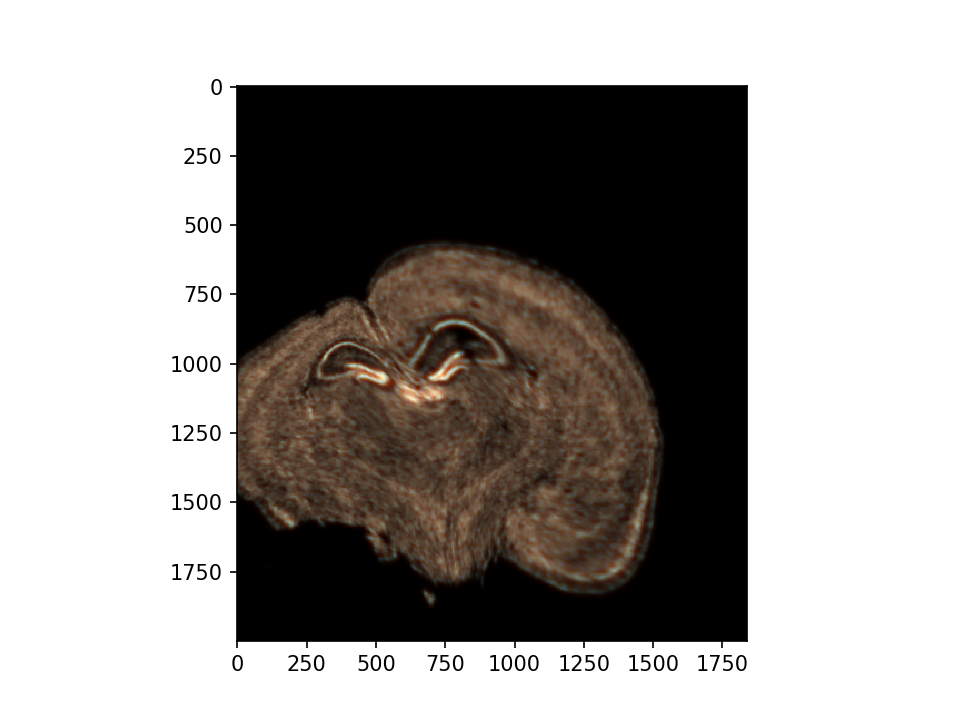

In [29]:
fig,ax = plt.subplots()
ax.imshow(((AI-torch.amin(AI,(1,2))[...,None,None])/(torch.amax(AI,(1,2))-torch.amin(AI,(1,2)))[...,None,None]).permute(1,2,0).clone().detach().cpu(),extent=extentJ)

<IPython.core.display.Javascript object>


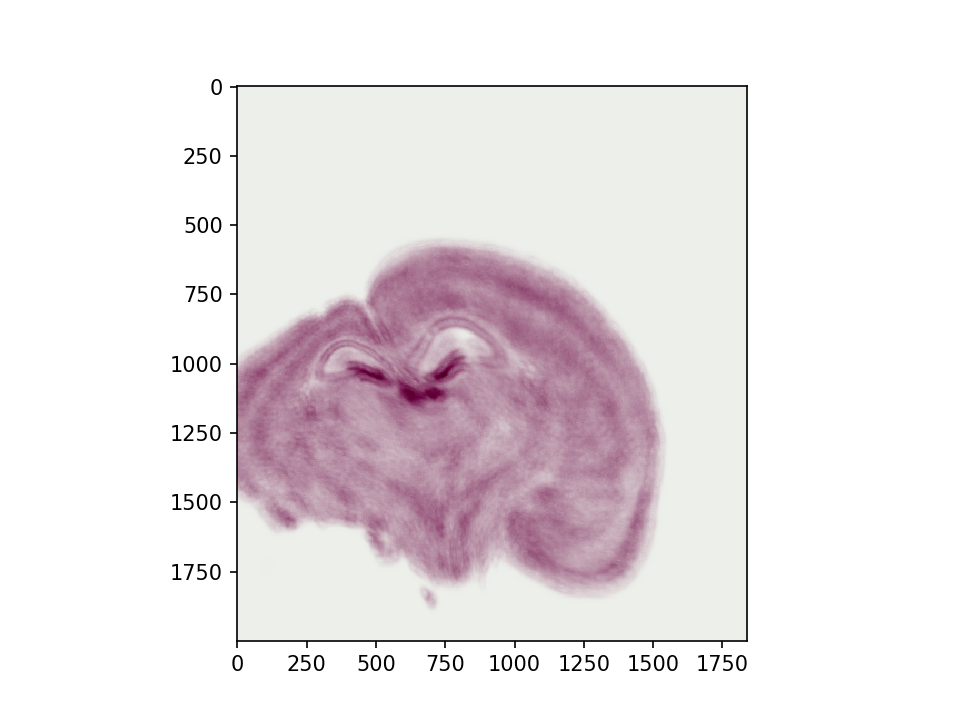

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [30]:
fig,ax = plt.subplots()
ax.imshow(fAI.clone().detach().permute(1,2,0).cpu(),extent=extentJ)

<IPython.core.display.Javascript object>


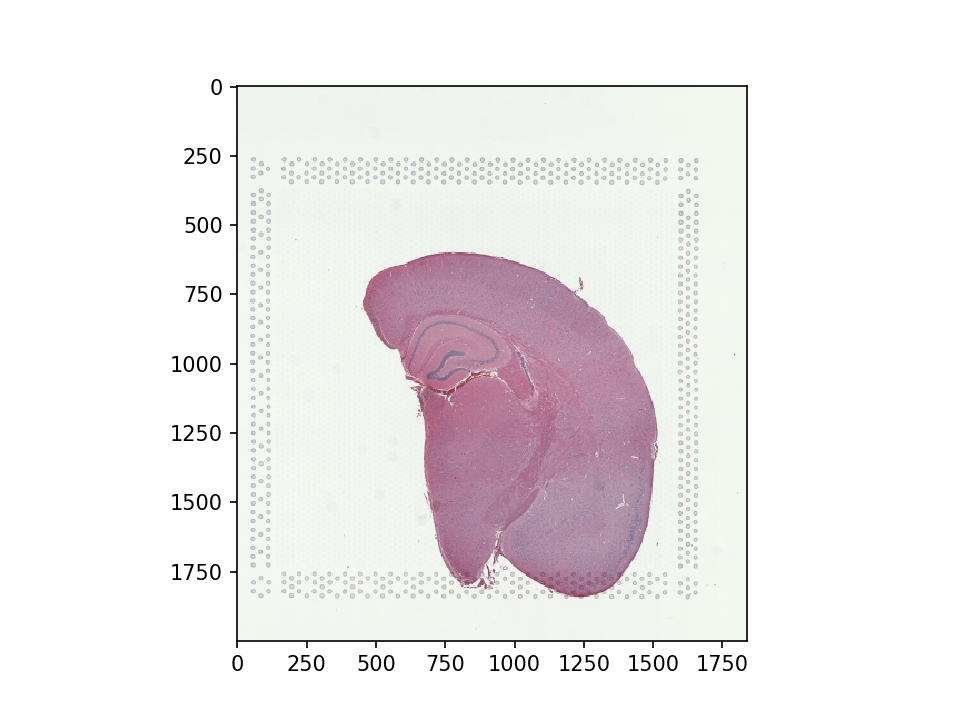

In [31]:
fig,ax = plt.subplots()
ax.imshow(Jd.permute(1,2,0).cpu(),extent=extentJ)

<IPython.core.display.Javascript object>


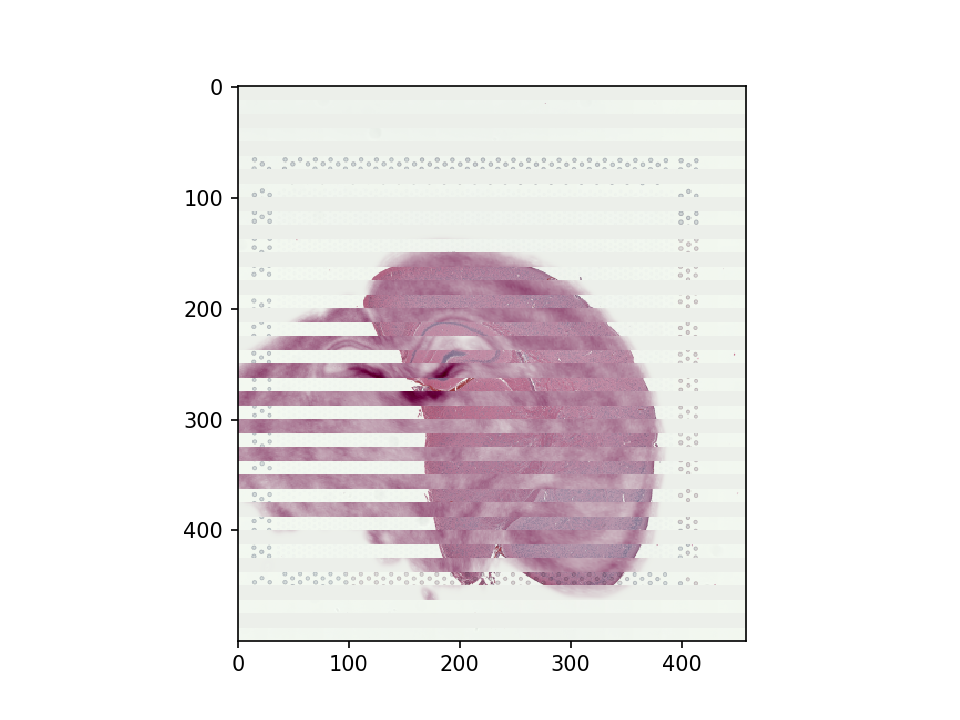

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [32]:
nstripe = 100
stripe = XJd[...,0]%nstripe > nstripe/2
fig,ax = plt.subplots()
ax.imshow((Jd*stripe + fAI*(1-stripe.float())).permute(1,2,0).clone().detach())

In [33]:
# next steps
# 1. let's try the second visium dataset, it has more missing data, but is likely a closer section plane
# 2. we should examine the gene expression alignment too.  At each spot, we look at cells in that region, 
#    and sum up gene expression, do we see a good correlation among genes that are sequenced in both types.
# note likely visium is like a noisy version of the merfish. differences in efficiency mean we cannot exactly 
# count the number or rnas.

In [34]:
# how is this related to KL distances. its related to correlations.

In [35]:
# points 

In [36]:
# what do we want to output?
# for each point in the merfish dataset
# we need to find the coordinate in the visium dataset

In [37]:
# points are in row column
# 
with torch.no_grad():
    pointsM = np.stack((y,x),-1)
    pointsM = torch.tensor(pointsM)
    pointsMt = torch.clone(pointsM)
    for t in range(nt):
        pointsMt += interp(xv,v[t].permute(2,0,1),pointsMt.T[...,None])[...,0].T/nt
    pointsMt = (A[:2,:2]@pointsMt.T + A[:2,-1][...,None]).T

<IPython.core.display.Javascript object>


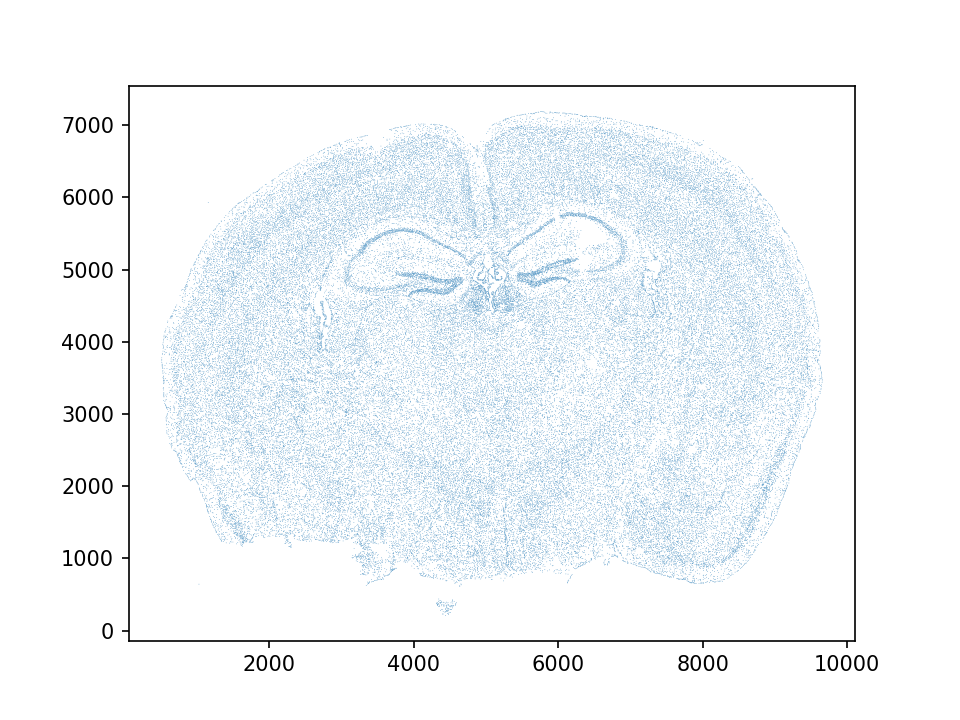

<IPython.core.display.Javascript object>


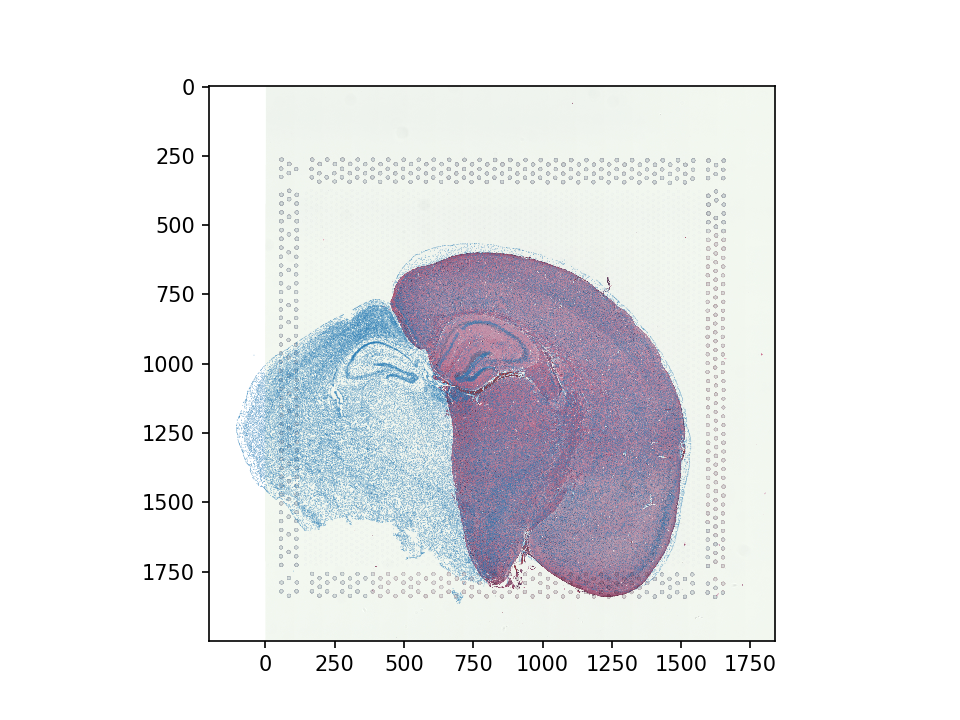

In [38]:
f,ax = plt.subplots()
ax.scatter(pointsM[:,1],pointsM[:,0],s=0.1,ec='none')
ax.set_aspect('equal')
f,ax = plt.subplots()
ax.imshow(J.permute(1,2,0),extent=extentJ)
ax.scatter(pointsMt[:,1],pointsMt[:,0],s=0.1,ec='none')
ax.set_aspect('equal')

In [39]:
#TODO, remove background cells (with blue label above)
# send x,y to jean


In [40]:
df

Unnamed: 0   fov       volume  \
0      158338042824236264719696604356349910479    33   532.778772   
1      260594727341160372355976405428092853003    33  1004.430016   
2      307643940700812339199503248604719950662    33  1267.183208   
3       30863303465976316429997331474071348973    33  1403.401822   
4      313162718584097621688679244357302162401    33   507.949497   
...                                        ...   ...          ...   
85953  311704042603434891559886168438769992293  1545  1625.490809   
85954  312851880059098327776181257829209599759  1545   905.032435   
85955  332299915869590281339501510603978852698  1545   459.647325   
85956  150462787759670321084458536479486602685  1546   778.386670   
85957  268870416870774615427277589169474700725  1546   592.088115   

          center_x     center_y        min_x        max_x        min_y  \
0       617.916619  2666.520010   614.725219   621.108019  2657.545209   
1       596.808018  2763.450012   589.669218   603.946818  2757.013212   
2       578.880018  2748.978012   570.877217   586.882818  2740.489211   
3       572.616017  2766.690012   564.937217   580.294818  2756.581212   
4       608.364018  2687.418010   603.061218   613.666818  2682.493210   
...            ...          ...          ...          ...          ...   
85953  9623.123579  4030.182069  9615.660779  9630.586379  4019.749269   
85954  9625.067579  4008.749469  9620.088779  9630.046379  4000.320068   
85955  9605.470978  4187.268073  9600.767578  9610.174378  4182.397273   
85956  9606.874978  4208.819338  9600.767578  9612.982378  4200.335938   
85957  9607.841578  4219.019938  9602.700778  9612.982378  4213.393138   

             max_y  
0      2675.494810  
1      2769.886812  
2      2757.466812  
3      2776.798812  
4      2692.342810  
...            ...  
85953  4040.614869  
85954  4017.178869  
85955  4192.138873  
85956  4217.302738  
85957  4224.646738  

[85958 rows x 9 columns]

In [41]:
# apply the forward transform to each cell

In [42]:
dfout = pd.DataFrame(df,copy=True)

In [43]:
dfout['rowvis'] = pointsMt[:,0]
dfout['colvis'] = pointsMt[:,1]

<IPython.core.display.Javascript object>


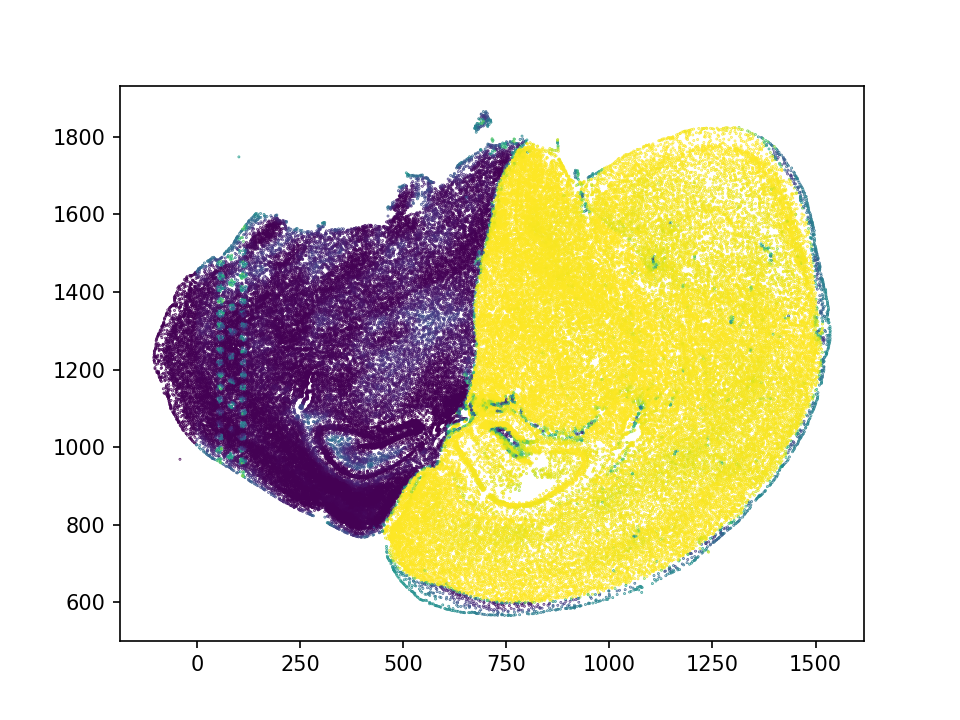

In [44]:
testM = interp(xJ,WM[None],pointsMt[None].permute(-1,0,1))
fig,ax = plt.subplots()
ax.scatter(pointsMt[:,1],pointsMt[:,0],c=testM[0,0],s=0.1)

In [45]:
dfout['Pvis'] = testM[0,0]

In [46]:
dfout.to_csv('forjean_march10b_2022')

In [47]:
dfout

Unnamed: 0   fov       volume  \
0      158338042824236264719696604356349910479    33   532.778772   
1      260594727341160372355976405428092853003    33  1004.430016   
2      307643940700812339199503248604719950662    33  1267.183208   
3       30863303465976316429997331474071348973    33  1403.401822   
4      313162718584097621688679244357302162401    33   507.949497   
...                                        ...   ...          ...   
85953  311704042603434891559886168438769992293  1545  1625.490809   
85954  312851880059098327776181257829209599759  1545   905.032435   
85955  332299915869590281339501510603978852698  1545   459.647325   
85956  150462787759670321084458536479486602685  1546   778.386670   
85957  268870416870774615427277589169474700725  1546   592.088115   

          center_x     center_y        min_x        max_x        min_y  \
0       617.916619  2666.520010   614.725219   621.108019  2657.545209   
1       596.808018  2763.450012   589.669218   603.946818  2757.013212   
2       578.880018  2748.978012   570.877217   586.882818  2740.489211   
3       572.616017  2766.690012   564.937217   580.294818  2756.581212   
4       608.364018  2687.418010   603.061218   613.666818  2682.493210   
...            ...          ...          ...          ...          ...   
85953  9623.123579  4030.182069  9615.660779  9630.586379  4019.749269   
85954  9625.067579  4008.749469  9620.088779  9630.046379  4000.320068   
85955  9605.470978  4187.268073  9600.767578  9610.174378  4182.397273   
85956  9606.874978  4208.819338  9600.767578  9612.982378  4200.335938   
85957  9607.841578  4219.019938  9602.700778  9612.982378  4213.393138   

             max_y       rowvis       colvis      Pvis  
0      2675.494810  1421.670436   -33.781665  0.000000  
1      2769.886812  1409.242315   -41.606276  0.000000  
2      2757.466812  1412.233483   -44.178331  0.000000  
3      2776.798812  1410.098527   -46.037109  0.000000  
4      2692.342810  1419.269594   -36.356578  0.000000  
...            ...          ...          ...       ...  
85953  4040.614869  1163.712963  1513.567001  0.459977  
85954  4017.178869  1167.941932  1514.551663  0.465274  
85955  4192.138873  1132.668771  1505.359193  0.483171  
85956  4217.302738  1128.249123  1504.728934  0.480618  
85957  4224.646738  1126.145785  1504.473555  0.468555  

[85958 rows x 12 columns]